In [1]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
from sklearn_pandas import DataFrameMapper
import warnings

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [2]:
NAMES = ('WBAN_number', 'UTC_date', 'UTC_time', 'LST_date', 'LST_time', 'CRX_version',
        'longitude', 'latitude', 'air_temperature', 'precepitation', 'solar_radiation',
        'SR_flag', 'surface_temperature', 'ST_type', 'ST_flag', 'relative_humidity', 'RH_flag',
        'soil_moisture', 'soil_temperature', 'wetness', 'wet_flag', 'wind', 'wind_flag')
temperature_data = pandas.read_table('./data/yosemite_village/CRNS0101-05-2011-CA_Yosemite_Village_12_W.txt',
                                    sep=r'\s+', header=None, names=NAMES)
temperature_data.head()

,WBAN_number,UTC_date,UTC_time,LST_date,LST_time,CRX_version,longitude,latitude,air_temperature,precepitation,...,ST_type,ST_flag,relative_humidity,RH_flag,soil_moisture,soil_temperature,wetness,wet_flag,wind,wind_flag
0,53150,20110101,5,20101231,1605,2,-119.82,37.76,-6.4,0.0,...,U,0,-9999,0,-99.0,-9999.0,1218,0,-99.0,0
1,53150,20110101,10,20101231,1610,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1223,0,-99.0,0
2,53150,20110101,15,20101231,1615,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1223,0,-99.0,0
3,53150,20110101,20,20101231,1620,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1224,0,-99.0,0
4,53150,20110101,25,20101231,1625,2,-119.82,37.76,-6.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1210,0,-99.0,0


In [3]:
limited_data = temperature_data.loc[:,('LST_date', 'LST_time', 'air_temperature')]
print(len(limited_data))
limited_data = limited_data.replace({-9999.0: None}).dropna()
print(len(limited_data))
limited_data.head()

105120
104968


,LST_date,LST_time,air_temperature
0,20101231,1605,-6.4
1,20101231,1610,-6.5
2,20101231,1615,-6.5
3,20101231,1620,-6.5
4,20101231,1625,-6.7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f36c9e8>]], dtype=object)

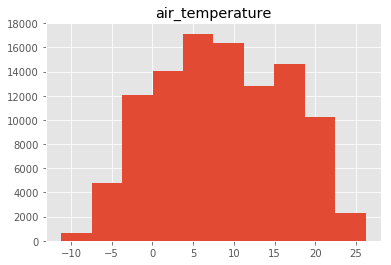

In [4]:
limited_data.hist('air_temperature')

## Seasonal variation
From https://www.nps.gov/yose/planyourvisit/weather.htm

The temperature peak appears to be in July/August, and the trough in December/January, so we can start by computing features as distance within the year from each (day 0, day 212, day 365). We can do something similar with the time of day later.

The hottest time of the day appears to be around 1500 or so.

In [5]:
DATE_FORMAT = '%Y%m%d'
limited_data['LST_day_of_year'] = [datetime.strptime(str(lst_date), DATE_FORMAT).timetuple().tm_yday
                                                     for lst_date in limited_data.LST_date]

limited_data.head()

,LST_date,LST_time,air_temperature,LST_day_of_year
0,20101231,1605,-6.4,365
1,20101231,1610,-6.5,365
2,20101231,1615,-6.5,365
3,20101231,1620,-6.5,365
4,20101231,1625,-6.7,365


## Split test and train

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(limited_data, test_size=0.1, random_state=RANDOM_SEED) # train_size=0.25,
print(train.shape, test.shape)
train.head()

(94471, 4) (10497, 4)


,LST_date,LST_time,air_temperature,LST_day_of_year
25469,20110330,230,7.3,89
47683,20110615,540,16.7,166
1843,20110107,140,6.3,7
71314,20110905,655,17.9,248
65489,20110816,130,14.4,228


## Defining a transformed to apply a pre-provided RBF

In [26]:
from sklearn.base import TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class RBFEncoder(TransformerMixin):
    def __init__(self, means, alpha):
        self.means = np.array(means).reshape((-1, 1))
        self.alpha = alpha
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # np.exp(- 1 / (2 * self.alpha ** 2) * (X - self.m) ** 2)
        X = X.reshape(-1, 1)
        return rbf_kernel(X, self.means, gamma=1 / (2 * self.alpha ** 2))

In [28]:
DAY_MEANS = (0, 212, 365)
DAY_ALPHA = 70
TIME_MEANS = (0, 1500, 2400)
TIME_ALPHA = 500


data_mapper = DataFrameMapper([
    ('LST_day_of_year', RBFEncoder(DAY_MEANS, DAY_ALPHA)),
    ('LST_time', RBFEncoder(TIME_MEANS, TIME_ALPHA)),
])

transformed_train = data_mapper.fit_transform(train.copy())
print(transformed_train.shape)
transformed_train[:5]

(94471, 6)


array([[  4.45630428e-01,   2.13573229e-01,   4.20922754e-04,
          8.99604551e-01,   3.97239897e-02,   8.12646049e-05],
       [  6.00945133e-02,   8.05801079e-01,   1.75813189e-02,
          5.58109555e-01,   1.58310023e-01,   9.88620521e-04],
       [  9.95012479e-01,   1.37287198e-02,   2.09080963e-06,
          9.61558378e-01,   2.47433132e-02,   3.66096021e-05],
       [  1.88106275e-03,   8.76126407e-01,   2.47378251e-01,
          4.23988053e-01,   2.39776030e-01,   2.26529565e-03],
       [  4.96923290e-03,   9.74215791e-01,   1.47311766e-01,
          9.66764838e-01,   2.34285480e-02,   3.34385879e-05]])

In [29]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

np.random.seed(33)


pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper),
    ('ridge', RidgeCV()),
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shuffled = train.sample(frac=1)
    cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.air_temperature, 
                                         scoring='mean_squared_error', cv=5), 3)
    print(np.average(cv_scores), cv_scores)
    
#     for k in range(3, 16):
#         pipe.set_params(select__k=k)
#         shuffled = data_train.sample(frac=1)
#         cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.like, scoring='r2', cv=7), 3)
#         print(k, np.average(cv_scores), cv_scores)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


-23.849 [-23.963 -24.054 -23.651 -23.641 -23.936]


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

shuffled = train.sample(frac=1)
pipe.fit(shuffled, shuffled.air_temperature)

test_predictions = pipe.predict(test)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(test_predictions, test.air_temperature))

mean_squared_error 23.4078255456
mean_absolute_error 3.89227342294
median_absolute_error 3.35972695985
r2_score 0.379167605902


In [11]:
a = np.array(train.LST_day_of_year).reshape((-1, 1))
a.shape

(94471, 1)

In [24]:
means = np.array((0, 212, 365)).reshape((-1, 1))

rbf_kernel(a[:100], means, gamma=0.001)

array([[  3.63039106e-04,   2.68880176e-07,   8.26387133e-34],
       [  1.07790691e-12,   1.20512717e-01,   6.33146517e-18],
       [  9.52181130e-01,   5.60756605e-19,   2.18314218e-56],
       [  1.94604189e-27,   2.73624103e-01,   1.13486143e-06],
       [  2.65237944e-23,   7.74141969e-01,   7.05873486e-09],
       [  1.94604189e-27,   2.73624103e-01,   1.13486143e-06],
       [  5.96680983e-26,   4.31279029e-01,   2.10033247e-07],
       [  1.18388039e-27,   2.54361194e-01,   1.43262805e-06],
       [  1.69189792e-10,   2.14077987e-02,   8.40886875e-21],
       [  9.52181130e-01,   5.60756605e-19,   2.18314218e-56],
       [  2.64598192e-24,   6.43392707e-01,   2.70927411e-08],
       [  9.80688278e-48,   1.13486143e-06,   2.73624103e-01],
       [  7.39534634e-10,   1.12318701e-02,   9.55316054e-22],
       [  9.98586094e-02,   2.08552603e-12,   2.28129689e-44],
       [  1.68887622e-36,   3.60656314e-03,   2.27904223e-03],
       [  2.54214936e-53,   9.27447346e-09,   7.4901220